In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np
import tensorflow as tf 
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
train_dir = 'data-augmented/ISIC2018/train/'
test_with_aug_dir = 'data-augmented/ISIC2018/test_with_aug/'
test_without_aug_dir = 'data-augmented/ISIC2018/test_without_aug/'

extracted_features_dir = "extracted_features/"
model_name = "VGG16_2018_Adam1_Adam2"

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_with_aug_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_without_aug_dir):
    print (root, len(files))

data-augmented/ISIC2018/train/ 0
data-augmented/ISIC2018/train/non-melanoma 8075
data-augmented/ISIC2018/train/melanoma 8759
******************************
data-augmented/ISIC2018/test_with_aug/ 0
data-augmented/ISIC2018/test_with_aug/non-melanoma 3692
data-augmented/ISIC2018/test_with_aug/melanoma 3951
******************************
data-augmented/ISIC2018/test_without_aug/ 0
data-augmented/ISIC2018/test_without_aug/non-melanoma 1836
data-augmented/ISIC2018/test_without_aug/melanoma 239


In [5]:
output_classes = 2
batch_size = 32
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 50

top_model_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_model.h5')
top_model_weights_path = os.path.join(extracted_features_dir, 'bottleneck_fc_'+model_name+'_weights.h5')

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
nb_test_samples = sum([len(files) for r, d, files in os.walk(test_with_aug_dir)])
nb_augmented_test_samples = sum([len(files) for r, d, files in os.walk(test_without_aug_dir)])

print("train samples:", nb_train_samples)
print("test without aug samples:", nb_test_samples)
print("test augmented samples:", nb_augmented_test_samples)

train samples: 16834
test without aug samples: 7643
test augmented samples: 2075


In [6]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

Found 12627 images belonging to 2 classes.


In [7]:
nb_train_samples = len(train_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("\npredict_size_train:", predict_size_train)

print("\n num_classes:", num_classes)

nb_train_samples: 12627

predict_size_train: 395

 num_classes: 2


In [8]:
bottleneck_model = applications.VGG16(include_top=False, weights='imagenet')
# print(bottleneck_model.summary())

In [9]:
bottleneck_features_train = bottleneck_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [10]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

nb_validation_samples = len(validation_generator.filenames)
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
print("nb_validation_samples:", nb_validation_samples)
print("predict_size_validation:", predict_size_validation)

Found 4207 images belonging to 2 classes.
nb_validation_samples: 4207
predict_size_validation: 132


In [11]:
bottleneck_features_validation = bottleneck_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [12]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

In [13]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt1=Adam(lr = 1e-05, beta_1=0.7, beta_2=0.995, epsilon=None, decay=0.0, amsgrad=True)
adam_opt2=Adam(lr = 1e-05, beta_1=0.8, beta_2=0.995, epsilon=None, decay=0.0, amsgrad=True)

model.compile(optimizer = adam_opt1, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 12627 samples, validate on 4207 samples
Epoch 1/50
 - 17s - loss: 0.5780 - acc: 0.6925 - val_loss: 0.4962 - val_acc: 0.7618
Epoch 2/50
 - 18s - loss: 0.5106 - acc: 0.7485 - val_loss: 0.4723 - val_acc: 0.7568
Epoch 3/50
 - 18s - loss: 0.4794 - acc: 0.7613 - val_loss: 0.4515 - val_acc: 0.7766
Epoch 4/50
 - 18s - loss: 0.4573 - acc: 0.7756 - val_loss: 0.4268 - val_acc: 0.7956
Epoch 5/50
 - 18s - loss: 0.4436 - acc: 0.7818 - val_loss: 0.4220 - val_acc: 0.7996
Epoch 6/50
 - 17s - loss: 0.4279 - acc: 0.7950 - val_loss: 0.4154 - val_acc: 0.8084
Epoch 7/50
 - 18s - loss: 0.4142 - acc: 0.8005 - val_loss: 0.4191 - val_acc: 0.7965
Epoch 8/50
 - 18s - loss: 0.4047 - acc: 0.8107 - val_loss: 0.4006 - val_acc: 0.8144
Epoch 9/50
 - 18s - loss: 0.3934 - acc: 0.8151 - val_loss: 0.4055 - val_acc: 0.8068
Epoch 10/50
 - 18s - loss: 0.3819 - acc: 0.8237 - val_loss: 0.4727 - val_acc: 0.7568
Epoch 11/50
 - 16s - loss: 0.3753 - acc: 0.8289 - val_loss: 0.3954 - val_acc: 0.8205
Epoch 12/50
 - 17s - loss

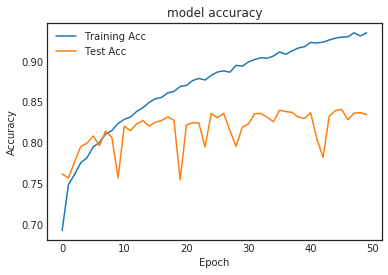

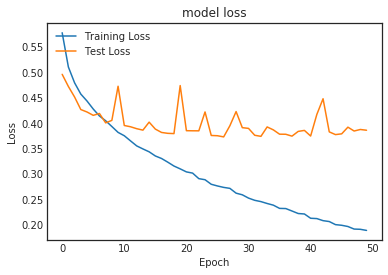

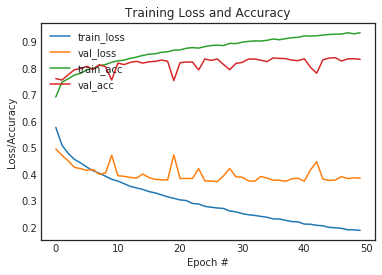

In [14]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [15]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

4207/4207 [==============================] - 2s 394us/step
Validation Accuracy: 83.4799%
Validation Loss: 0.38608728278723187


___
# Test without augmentation

In [16]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_without_aug_generator = test_datagen.flow_from_directory(
    test_without_aug_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 2075 images belonging to 2 classes.


In [17]:
nb_test_without_aug_samples = len(test_without_aug_generator.filenames)
predict_size_without_aug_test = int(math.ceil(nb_test_without_aug_samples / batch_size))

print("nb_aug_test_samples:", nb_test_without_aug_samples)
print("predict_size_test_aug:", predict_size_without_aug_test)

nb_aug_test_samples: 2075
predict_size_test_aug: 65


In [18]:
bottleneck_features_without_aug_test = bottleneck_model.predict_generator(test_without_aug_generator, predict_size_without_aug_test)
np.save(extracted_features_dir+'bottleneck_features_test_adam1_without_aug'+model_name+'.npy', bottleneck_features_without_aug_test)

In [19]:
test_data_without_aug = np.load(extracted_features_dir+'bottleneck_features_test_adam1_without_aug'+model_name+'.npy')

test_labels_without_aug = test_without_aug_generator.classes
test_labels_without_aug = to_categorical(test_labels_without_aug, num_classes=num_classes)

In [20]:
preds2 = model.predict(test_data_without_aug)

predictions2 = [i.argmax() for i in preds2]
y_true2 = [i.argmax() for i in test_labels_without_aug]
cm = confusion_matrix(y_pred=predictions2, y_true=y_true2)

print('Accuracy {}'.format(accuracy_score(y_true=y_true2, y_pred=predictions2)))

Accuracy 0.7672289156626506


Confusion Matrix
[[ 211   28]
 [ 455 1381]]


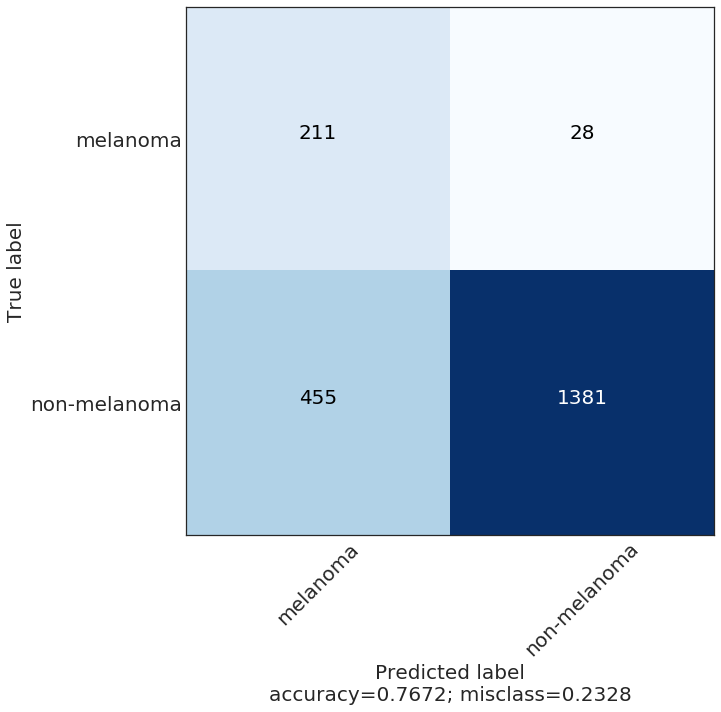

In [21]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_without_aug_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions2
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true2

classnames=[]
for classname in test_without_aug_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[ 211   28]
 [ 455 1381]]
              precision    recall  f1-score   support

    melanoma       0.32      0.88      0.47       239
non-melanoma       0.98      0.75      0.85      1836

   micro avg       0.77      0.77      0.77      2075
   macro avg       0.65      0.82      0.66      2075
weighted avg       0.90      0.77      0.81      2075



In [23]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  76.72289156626506
Sensitivity :  31.681681681681685
Specificity :  98.01277501774308


In [24]:
print('roc_auc_score = ' + str(roc_auc_score(predictions2, y_true2)))

roc_auc_score = 0.6484722834971238


In [25]:
fpr, tpr, thresholds = roc_curve(y_true2, predictions2)
roc_auc = auc(fpr,tpr)

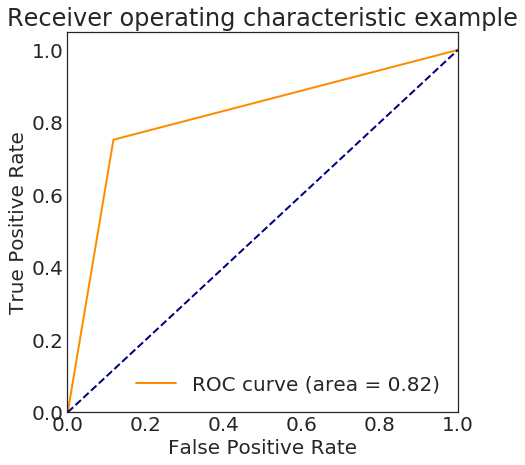

In [26]:
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [27]:
predict = model.predict_proba(test_data_without_aug, batch_size=batch_size, verbose=1)

2075/2075 [==============================] - 1s 401us/step


In [28]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels_without_aug, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [29]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

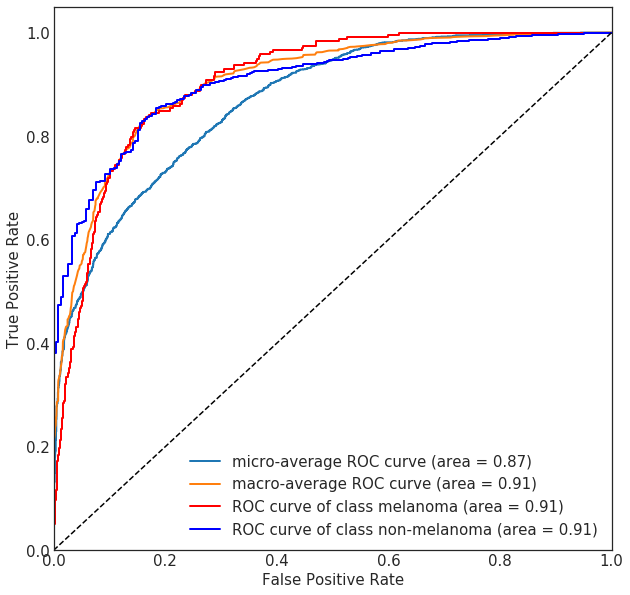

In [30]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_without_aug_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [31]:
tn, fp, fn, tp = cm.ravel()

In [32]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn) 

Accuracy: 0.7672289156626506
Precision: 0.9801277501774308
Recall: 0.7521786492374728
tp: 1381
fp: 28
tn: 211
fn: 455


In [33]:
# y_pred = np.argmax(y_pred,axis = 1) 

print('F1 score:', f1_score(y_true2, y_pred))

F1 score: 0.85115562403698


In [34]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.85115562403698


___
 # Augmented_test

In [35]:
test_with_aug_generator = test_datagen.flow_from_directory(
    test_with_aug_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

nb_test_with_aug_samples = len(test_with_aug_generator.filenames)
predict_size_test_with_aug = int(math.ceil(nb_test_with_aug_samples / batch_size))
print("nb_test_samples:", nb_test_with_aug_samples)
print("predict_size_test:", predict_size_test_with_aug)

test_labels_aug = test_with_aug_generator.classes
test_labels_aug = to_categorical(test_labels_aug, num_classes=num_classes)

Found 7643 images belonging to 2 classes.
nb_test_samples: 7643
predict_size_test: 239


In [36]:
bottleneck_features_test_with_aug = bottleneck_model.predict_generator(test_with_aug_generator, predict_size_test_with_aug)
np.save(extracted_features_dir+'bottleneck_features_test_adam1_with_aug'+model_name+'.npy', bottleneck_features_test_with_aug)

test_data_aug = np.load(extracted_features_dir+'bottleneck_features_test_adam1_with_aug'+model_name+'.npy')

In [37]:
preds = model.predict(test_data_aug)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels_aug]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8283396572026691


Confusion Matrix
[[3565  386]
 [ 926 2766]]


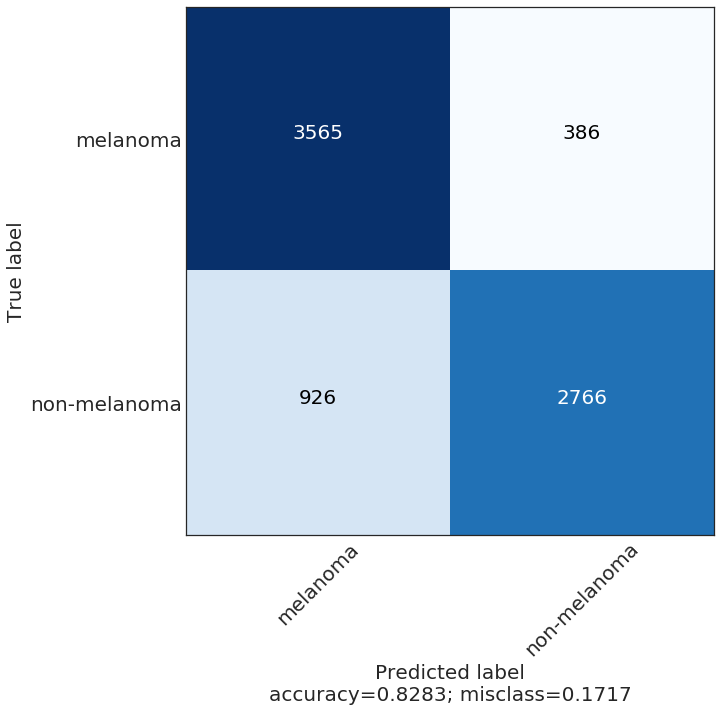

In [38]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_with_aug_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title=' ')

In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_with_aug_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[3565  386]
 [ 926 2766]]
              precision    recall  f1-score   support

    melanoma       0.79      0.90      0.84      3951
non-melanoma       0.88      0.75      0.81      3692

   micro avg       0.83      0.83      0.83      7643
   macro avg       0.84      0.83      0.83      7643
weighted avg       0.83      0.83      0.83      7643



In [40]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  82.83396572026692
Sensitivity :  79.38098419060343
Specificity :  87.75380710659898


In [41]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8356739564860122


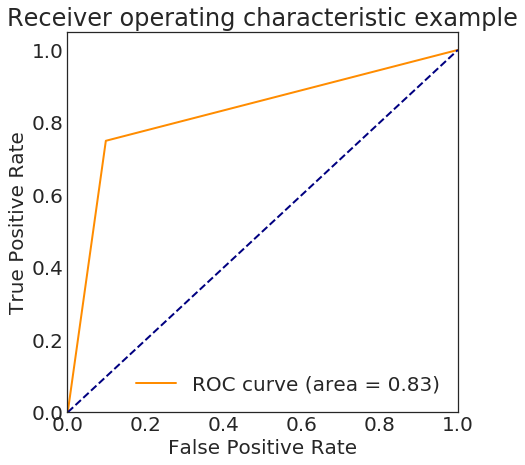

In [42]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [43]:
predict = model.predict_proba(test_data_aug, batch_size=batch_size, verbose=1)

from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels_aug, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

7643/7643 [==============================] - 2s 321us/step


In [44]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

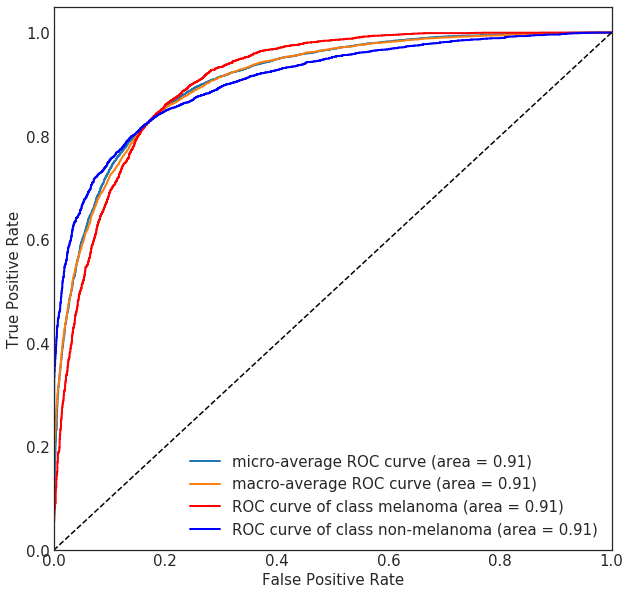

In [45]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_with_aug_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [46]:
tn, fp, fn, tp = cm.ravel()

print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn) 

Accuracy: 0.8283396572026691
Precision: 0.8775380710659898
Recall: 0.7491874322860238
tp: 2766
fp: 386
tn: 3565
fn: 926


In [47]:
# y_pred = np.argmax(y_pred,axis = 1) 

print('F1 score:', f1_score(y_true, y_pred))

recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8082992402104032
F1 score: 0.8082992402104033


# Adam optimizer2

In [48]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt1=Adam(lr = 1e-05, beta_1=0.7, beta_2=0.995, epsilon=None, decay=0.0, amsgrad=True)
adam_opt2=Adam(lr = 1e-05, beta_1=0.8, beta_2=0.995, epsilon=None, decay=0.0, amsgrad=True)

model.compile(optimizer = adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_Adam2'+model_name+'.txt','w') as f:
    f.write(str(history.history))

model.save_weights(top_model_weights_path)
model.save(top_model_path)

Train on 12627 samples, validate on 4207 samples
Epoch 1/50
 - 19s - loss: 0.5842 - acc: 0.6950 - val_loss: 0.5011 - val_acc: 0.7635
Epoch 2/50
 - 19s - loss: 0.5113 - acc: 0.7502 - val_loss: 0.4682 - val_acc: 0.7656
Epoch 3/50
 - 18s - loss: 0.4845 - acc: 0.7609 - val_loss: 0.4442 - val_acc: 0.7918
Epoch 4/50
 - 17s - loss: 0.4638 - acc: 0.7761 - val_loss: 0.4301 - val_acc: 0.7982
Epoch 5/50
 - 16s - loss: 0.4446 - acc: 0.7859 - val_loss: 0.4304 - val_acc: 0.7884
Epoch 6/50
 - 17s - loss: 0.4284 - acc: 0.7936 - val_loss: 0.4436 - val_acc: 0.7963
Epoch 7/50
 - 17s - loss: 0.4197 - acc: 0.8007 - val_loss: 0.4305 - val_acc: 0.7875
Epoch 8/50
 - 18s - loss: 0.4094 - acc: 0.8052 - val_loss: 0.4310 - val_acc: 0.7856
Epoch 9/50
 - 17s - loss: 0.4003 - acc: 0.8119 - val_loss: 0.4594 - val_acc: 0.7706
Epoch 10/50
 - 18s - loss: 0.3898 - acc: 0.8194 - val_loss: 0.4092 - val_acc: 0.8015
Epoch 11/50
 - 18s - loss: 0.3787 - acc: 0.8272 - val_loss: 0.3977 - val_acc: 0.8172
Epoch 12/50
 - 18s - loss

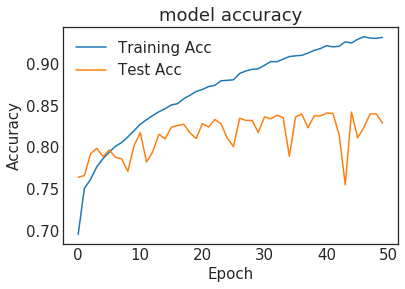

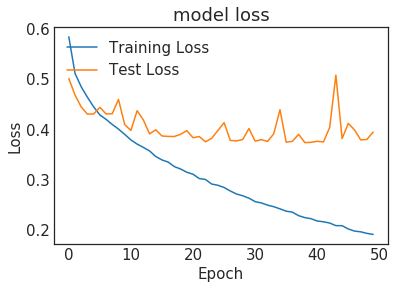

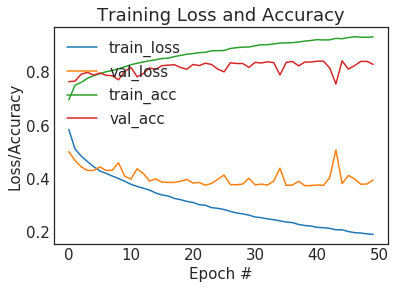

In [49]:
import seaborn
plt.style.use('seaborn-white')

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [50]:
(eval_loss, eval_accuracy) = model.evaluate(validation_data, validation_labels, batch_size= batch_size, verbose=1)

print("Validation Accuracy: {:.4f}%".format(eval_accuracy * 100))
print("Validation Loss: {}".format(eval_loss))

4207/4207 [==============================] - 2s 364us/step
Validation Accuracy: 82.8381%
Validation Loss: 0.39443270122180335


# Test without augmentation

In [51]:
preds = model.predict(test_data_without_aug)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels_without_aug]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.7908433734939759


Confusion Matrix
[[ 209   30]
 [ 404 1432]]


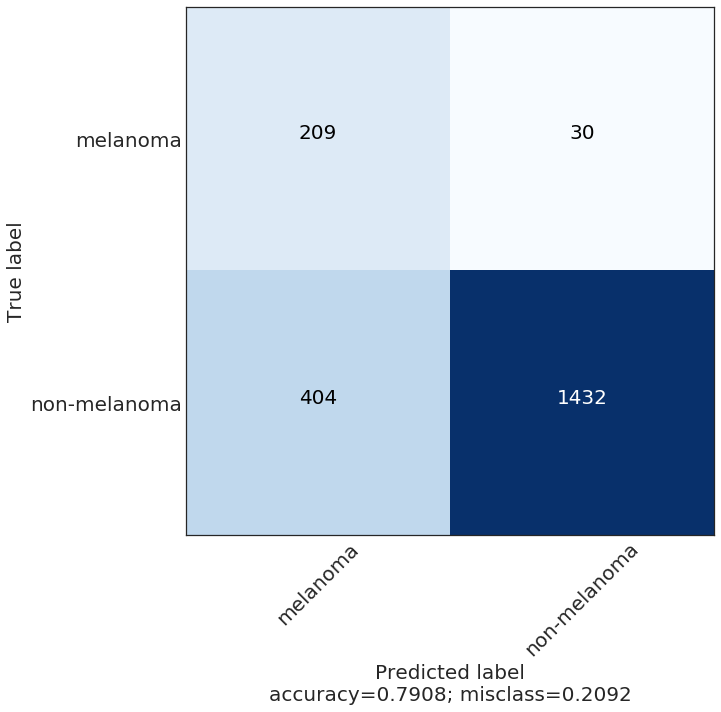

In [52]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_without_aug_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [53]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_without_aug_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[ 209   30]
 [ 404 1432]]
              precision    recall  f1-score   support

    melanoma       0.34      0.87      0.49       239
non-melanoma       0.98      0.78      0.87      1836

   micro avg       0.79      0.79      0.79      2075
   macro avg       0.66      0.83      0.68      2075
weighted avg       0.91      0.79      0.82      2075



In [54]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  79.0843373493976
Sensitivity :  34.09461663947798
Specificity :  97.94801641586868


In [55]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.6602131652767333


In [56]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

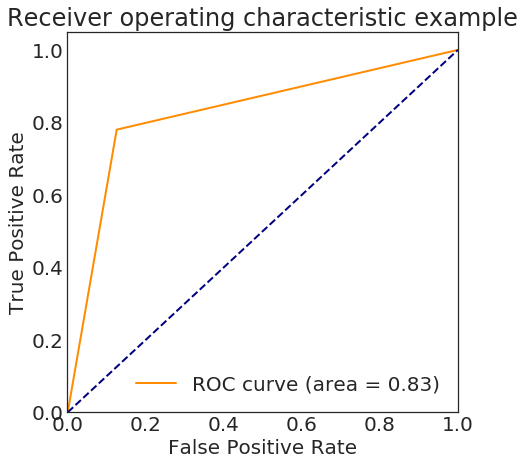

In [57]:
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [58]:
predict = model.predict_proba(test_data_without_aug, batch_size=batch_size, verbose=1)

2075/2075 [==============================] - 1s 615us/step


In [59]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels_without_aug, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [60]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

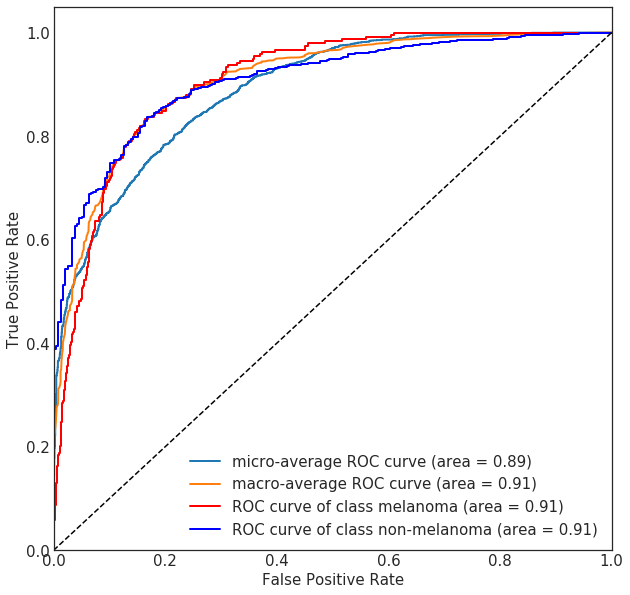

In [61]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_without_aug_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [62]:
tn, fp, fn, tp = cm.ravel()

print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn) 

Accuracy: 0.7908433734939759
Precision: 0.9794801641586868
Recall: 0.7799564270152506
tp: 1432
fp: 30
tn: 209
fn: 404


In [63]:
# y_pred = np.argmax(y_pred,axis = 1) 

print('F1 score:', f1_score(y_true, y_pred))

recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8684050939963615
F1 score: 0.8684050939963616


# Augmented_test

In [64]:
preds = model.predict(test_data_aug)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels_aug]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8318723014523093


Confusion Matrix
[[3478  473]
 [ 812 2880]]


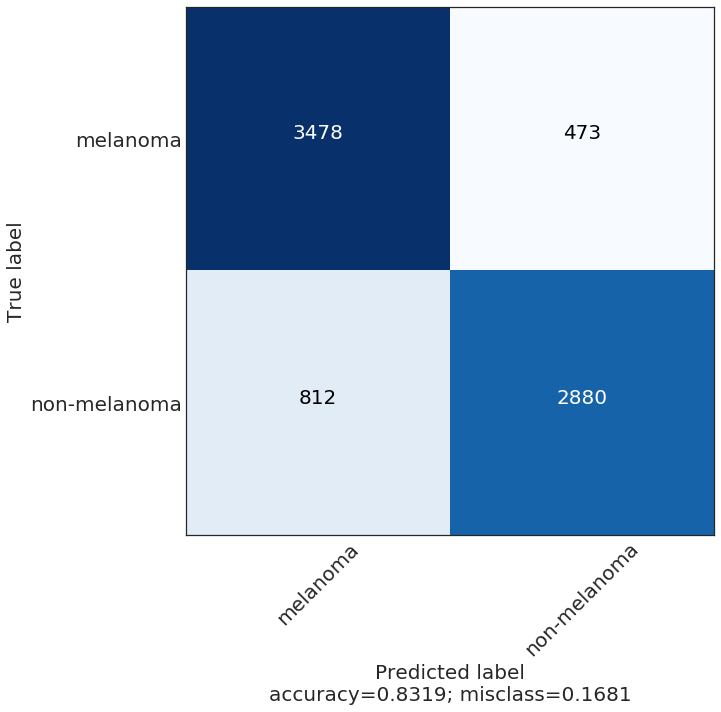

In [65]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_with_aug_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels, title=' ')

In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_with_aug_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[3478  473]
 [ 812 2880]]
              precision    recall  f1-score   support

    melanoma       0.81      0.88      0.84      3951
non-melanoma       0.86      0.78      0.82      3692

   micro avg       0.83      0.83      0.83      7643
   macro avg       0.83      0.83      0.83      7643
weighted avg       0.83      0.83      0.83      7643



In [67]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  83.18723014523093
Sensitivity :  81.07226107226107
Specificity :  85.89322994333432


In [68]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8348274550779771


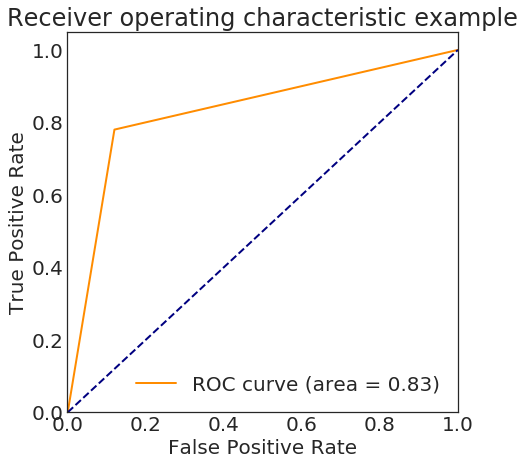

In [69]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [70]:
predict = model.predict_proba(test_data_aug, batch_size=batch_size, verbose=1)

from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels_aug, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

7643/7643 [==============================] - 7s 969us/step


In [71]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

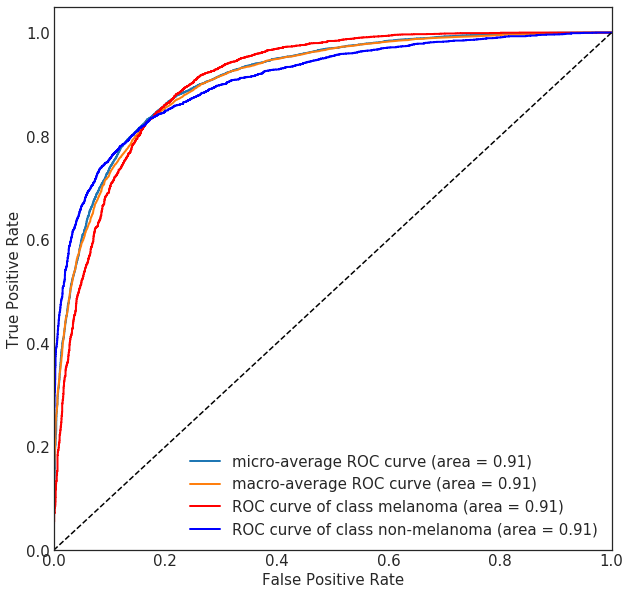

In [72]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_with_aug_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [73]:
tn, fp, fn, tp = cm.ravel()

print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn) 

Accuracy: 0.8318723014523093
Precision: 0.8589322994333433
Recall: 0.7800650054171181
tp: 2880
fp: 473
tn: 3478
fn: 812


In [74]:
print('F1 score:', f1_score(y_true, y_pred))

recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.8176011355571328
F1 score: 0.8176011355571328
